# GNN GCN Explainer

What you’re training the model to do

Input features are just node IDs (learned embeddings) for gene and cell-type nodes.

Graph structure carries the signed up/down relations; the GCN mixes information along +/− edges (signed normalization keeps things stable).

Targets:

For genes: a single “LBL_<CellType>_UP/DOWN” token selected by a simple rule (prefer UP; fixed CT order breaks ties). This makes it a single-label node-classification toy.

For cell types: predict their own identity token (helps the model stabilize and use structure consistently).

You can expand this to multi-label (predict all CTs per gene) by switching the head to a sigmoid multilabel loss and building a multi-hot target, or to edge prediction by moving to a link-prediction setup—but this minimal version keeps things simple and trains fast.

## Text Prep/Tokenization

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
cell_types = ['Tcells','Bcells','Macrophages']
genes = ['CD3D','TRAC','LCK','CD19','MS4A1','CD14','CSF1R']
node_order = genes + [f'CT_{ct}' for ct in cell_types]   # genes first, then CT nodes
N = len(node_order)  # 7 + 3 = 10 (a little larger but still small)

In [3]:
wild_type = {
    'Tcells':{'up': ['CD3D','TRAC','LCK','ZAP70'],'down': ['CD19','MS4A1','CD14']},
    'Bcells':{'up': ['CD19','MS4A1'],'down': ['CD3D','TRAC','LCK','CD14','ZAP70']},
    'Macrophages':{'up': ['CD14','CSF1R'],'down': ['CD3D','MS4A1','CD19']},
}

cancerous = {
    'Tcells':{'up': ['CD3D','TRAC','ZAP70'],'down': ['CD19','MS4A1','CD14','LCK']},
    'Bcells':{'up': ['CD19','ZAP70'],'down': ['CD3D','TRAC','LCK','CD14','MS4A1']},
    'Macrophages':{'up': ['CD14','CSF1R'],'down': ['CD3D','MS4A1','CD19']},
}

In [4]:
# ----- vocab: node ids + per-gene labels (LBL_<CT>_UP/DOWN) + CT identity tokens -----
def build_vocab(genes, cell_types):
    toks = []
    toks += genes
    toks += [f'CT_{ct}' for ct in cell_types]
    for ct in cell_types:
        toks += [f'LBL_{ct}_UP', f'LBL_{ct}_DOWN']
    stoi = {t:i for i,t in enumerate(toks)}
    itos = {i:t for t,i in stoi.items()}
    return stoi, itos

stoi, itos = build_vocab(genes, cell_types)
vocab_size = len(stoi)

In [6]:
# ----- build tensors for one graph spec -----
def make_graph_tensors(spec, genes, cell_types, node_order, stoi):
    N = len(node_order)
    A = torch.zeros(N, N)
    def add_edge(g, ct, sign):
        i = node_order.index(g); j = node_order.index(f"CT_{ct}")
        A[i,j] = sign; A[j,i] = sign
    for ct, rel in spec.items():
        for g in rel["up"]:
            if g in genes: add_edge(g, ct, +1)
        for g in rel["down"]:
            if g in genes: add_edge(g, ct, -1)
    X_tokens = torch.tensor([stoi[n] for n in node_order], dtype=torch.long)
    # single-label target per node:
    Y = []
    for n in node_order:
        if n in genes:
            # prefer UP if present for that gene; otherwise choose a DOWN; tie-break by CT list order
            up_cts   = [ct for ct in cell_types if n in spec.get(ct,{}).get("up",[])]
            down_cts = [ct for ct in cell_types if n in spec.get(ct,{}).get("down",[])]
            target = None
            for ct in cell_types:
                if ct in up_cts:   target = f"LBL_{ct}_UP"; break
            if target is None:
                for ct in cell_types:
                    if ct in down_cts: target = f"LBL_{ct}_DOWN"; break
            if target is None: target = n  # fallback (shouldn’t hit with our specs)
            Y.append(stoi[target])
        else:
            # CT node supervised to its identity token
            Y.append(stoi[n])
    Y_tokens = torch.tensor(Y, dtype=torch.long)
    return X_tokens, Y_tokens, A

In [7]:
# ----- assemble batch for SimpleGCNText -----
X1, Y1, A1 = make_graph_tensors(wild_type, genes, cell_types, node_order, stoi)
X1, Y1, A1

(tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 tensor([10, 10, 10, 12, 12, 14, 14,  7,  8,  9]),
 tensor([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., -1., -1.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., -1.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., -1.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  1., -1.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  1., -1.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -1., -1.,  1.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
         [ 1.,  1.,  1., -1., -1., -1.,  0.,  0.,  0.,  0.],
         [-1., -1., -1.,  1.,  1., -1.,  0.,  0.,  0.,  0.],
         [-1.,  0.,  0., -1., -1.,  1.,  1.,  0.,  0.,  0.]]))

In [8]:
X2, Y2, A2 = make_graph_tensors(cancerous, genes, cell_types, node_order, stoi)
X2, Y2, A2

(tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 tensor([10, 10, 11, 12, 11, 14, 14,  7,  8,  9]),
 tensor([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., -1., -1.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., -1.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -1., -1.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  1., -1.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -1., -1., -1.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -1., -1.,  1.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
         [ 1.,  1., -1., -1., -1., -1.,  0.,  0.,  0.,  0.],
         [-1., -1., -1.,  1., -1., -1.,  0.,  0.,  0.,  0.],
         [-1.,  0.,  0., -1., -1.,  1.,  1.,  0.,  0.,  0.]]))

In [9]:
import networkx as nx
import matplotlib.pyplot as plt

def graph_from_adjacency(A, node_order, genes):
    G = nx.Graph()
    for n in node_order:
        G.add_node(n, bipartite=(0 if n in genes else 1))
    N = len(node_order)
    for i in range(N):
        for j in range(i+1, N):
            s = float(A[i, j])
            if s != 0:
                G.add_edge(node_order[i], node_order[j], sign=int(s))
    return G

def draw_signed_bipartite(G, node_order, genes, ax=None, title=''):
    if ax is None:
        _, ax = plt.subplots(figsize=(6, 4))
    left  = [n for n,d in G.nodes(data=True) if d['bipartite'] == 0]
    right = [n for n,d in G.nodes(data=True) if d['bipartite'] == 1]

    # Simple 2-column bipartite layout
    pos = {}
    for i, n in enumerate(left):  pos[n] = (0.0, i)
    for j, n in enumerate(right): pos[n] = (1.0, j)

    # Nodes
    nx.draw_networkx_nodes(G, pos, nodelist=left,  node_shape='o', ax=ax)
    nx.draw_networkx_nodes(G, pos, nodelist=right, node_shape='s', ax=ax)

    # Edges: solid for + (upregulated), dashed for - (downregulated)
    pos_edges = [(u,v) for u,v,d in G.edges(data=True) if d['sign'] > 0]
    neg_edges = [(u,v) for u,v,d in G.edges(data=True) if d['sign'] < 0]
    nx.draw_networkx_edges(G, pos, edgelist=pos_edges, style='solid',  ax=ax)
    nx.draw_networkx_edges(G, pos, edgelist=neg_edges, style='dashed', ax=ax)

    # Labels
    nx.draw_networkx_labels(G, pos, font_size=9, ax=ax)

    # Legend proxies
    from matplotlib.lines import Line2D
    ax.legend(
        [Line2D([0],[0], linestyle='solid'),
         Line2D([0],[0], linestyle='dashed')],
        ['upregulated (+)', 'downregulated (−)'], loc='upper right', frameon=False
    )
    ax.set_title(title)
    ax.axis('off')
    return ax

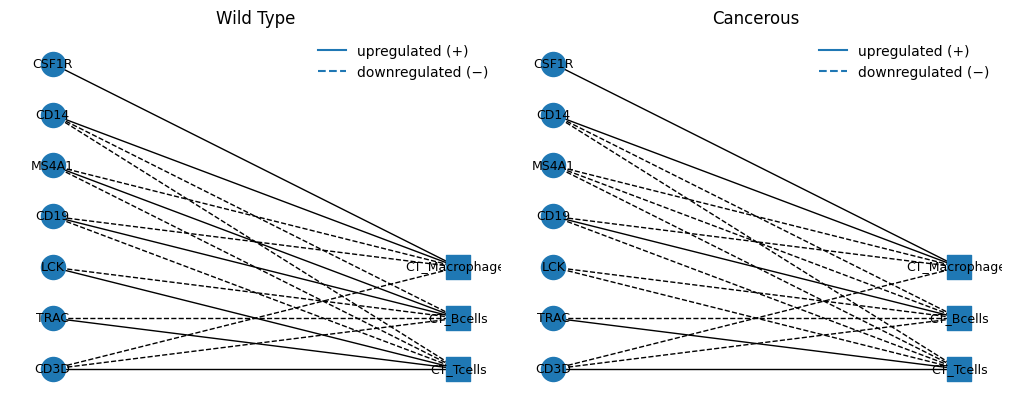

In [10]:
# Build and draw both graphs
G1 = graph_from_adjacency(A1, node_order, genes)
G2 = graph_from_adjacency(A2, node_order, genes)

fig, axes = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)
draw_signed_bipartite(G1, node_order, genes, ax=axes[0], title='Wild Type')
draw_signed_bipartite(G2, node_order, genes, ax=axes[1], title='Cancerous')
plt.show()


# Modeling

A machine learning model forward pass now uses the tokenization information, runs several layers of linear algebra on it, and then "predicts" the probability that each token in the vocab is next. When it is noisy (like you will see in this example), this process results in gibberish.  The training process changes the noise to pattern during the "backward pass" as you'll see. We'll show 3 steps that are focused on training:
1. **Data Loading** `x, y = train_loader.next_batch()` - this step pulls from the raw data enough tokens to complete a forward pass and loss calculation.  If the model is inference only, this step is replaced with taking in the inference input and preparing it similarly as the forward pass.
2. **Forward Pass** `logits, loss = model(x, y)` - using the data and the model architecture we run a prediction for the tokens. When training we also compare against the expected to get loss, but in inference, we use the logits to complete the inference task.
3. **Back Propagation, aka Backward Pass & Training** `loss.backward(); optimizer.step()` - using differentials to understand what parameters most impact the forward pass' impact on its prediction, comparing that against what is actually right based on the data loading step, and then making very minor adjustments to the impactful parameters with the hope it improves future predictions.

The we'll show a final **Forward Pass** with the updated weights we did in #3. 

## Data Loading

To start, we need to get enough data to run the forward and backward passes.  Since our total dataset is likely too big to be held in memory all at once in real practice, we will read just enough file information into memory so that we can run the passes, leaving memory and compute to be used on the passes instead of static data holding. 
To start, we have to identify the batch size and the model context length to determine how much data we need.  Consequently, these dimensions also form 2 of the 3 dimensions in the initial matrix.
- **Batch Size (B)** - This is the number of examples you'll train on in a single pass. 
- **Number of Nodes (N)** - This is basically the "context length" for a GNN.  This is the max number of node that a model can use in a pass.

Beyond these, in a GCN, the depth also controls how much "context" or complexity can be learned. This is because each GCN layer learns 1 hop, or 1 relationship of neighbors. This means that after $L$ layers, a model can learn $L$-hops worth of context.

In our case we'll set our Batch to be our 2 examples, nodes to the the nodes we have configured, 10, and our GCN will have 2 layers to model 2 network hops: gene → cell type → other genes

In [11]:
x_tokens = torch.stack([X1, X2], dim=0)     # [B=2, N=10]
x_tokens

tensor([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]])

In [12]:
y_labels = torch.stack([Y1, Y2], dim=0)     # [2, 10]
y_labels

tensor([[10, 10, 10, 12, 12, 14, 14,  7,  8,  9],
        [10, 10, 11, 12, 11, 14, 14,  7,  8,  9]])

In [13]:
a_list   = [A1.float(), A2.float()]         # list of [10,10] signed adjacencies
a_list

[tensor([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., -1., -1.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., -1.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., -1.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  1., -1.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  1., -1.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -1., -1.,  1.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
         [ 1.,  1.,  1., -1., -1., -1.,  0.,  0.,  0.,  0.],
         [-1., -1., -1.,  1.,  1., -1.,  0.,  0.,  0.,  0.],
         [-1.,  0.,  0., -1., -1.,  1.,  1.,  0.,  0.,  0.]]),
 tensor([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., -1., -1.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., -1.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -1., -1.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  1., -1.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -1., -1., -1.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -1., -1.,  1.],
         [ 0.,  0.,  0

In [14]:
B_batch, N_nodes = x_tokens.shape
B_batch, N_nodes

(2, 10)

## Forward pass

### Input Layer

In [15]:
n_embd = 3 # level of embedding of input tokens
vocab_size, n_embd

(16, 3)

#### Input Layer - Embedding Projection

In [18]:
tok_emb = nn.Embedding(vocab_size, n_embd)
with torch.no_grad(): # initilize to W[i,j] = 0.001*(1+i+j) for easy following 
    nn.init.ones_(tok_emb.weight)
tok_emb.weight

Parameter containing:
tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]], requires_grad=True)

In [22]:
x = tok_emb(x_tokens)
x

tensor([[[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]]], grad_fn=<EmbeddingBackward0>)

collapse out batch for learning

In [24]:
x = x.view(B_batch*N_nodes,n_embd)
x

tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]], grad_fn=<ViewBackward0>)

#### Input Layer - Normalization A

$Â = D^{-1/2}(A + I)D^{-1/2}$

In [29]:
A = a_list[0]
A

tensor([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., -1., -1.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., -1.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., -1.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  1., -1.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  1., -1.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -1., -1.,  1.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
        [ 1.,  1.,  1., -1., -1., -1.,  0.,  0.,  0.,  0.],
        [-1., -1., -1.,  1.,  1., -1.,  0.,  0.,  0.,  0.],
        [-1.,  0.,  0., -1., -1.,  1.,  1.,  0.,  0.,  0.]])

In [30]:
I = torch.eye(A.size(0))
I

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [31]:
A_hat = A + I
A_hat

tensor([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  1., -1., -1.],
        [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  1., -1.,  0.],
        [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  1., -1.,  0.],
        [ 0.,  0.,  0.,  1.,  0.,  0.,  0., -1.,  1., -1.],
        [ 0.,  0.,  0.,  0.,  1.,  0.,  0., -1.,  1., -1.],
        [ 0.,  0.,  0.,  0.,  0.,  1.,  0., -1., -1.,  1.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.],
        [ 1.,  1.,  1., -1., -1., -1.,  0.,  1.,  0.,  0.],
        [-1., -1., -1.,  1.,  1., -1.,  0.,  0.,  1.,  0.],
        [-1.,  0.,  0., -1., -1.,  1.,  1.,  0.,  0.,  1.]])

In [33]:
deg = A_hat.sum(dim=1)
deg

tensor([ 0.,  1.,  1.,  0.,  0.,  0.,  2.,  1., -1.,  0.])

In [34]:
D_inv_sqrt = torch.diag(torch.pow(deg, -0.5))
D_inv_sqrt

tensor([[   inf, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000,    inf, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000,    inf, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000,    inf, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.7071, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,    nan,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
            inf]])

In [36]:
A = D_inv_sqrt @ A_hat @ D_inv_sqrt
A

tensor([[   nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
            nan],
        [   nan, 1.0000, 0.0000,    nan,    nan,    nan, 0.0000, 1.0000,    nan,
            nan],
        [   nan, 0.0000, 1.0000,    nan,    nan,    nan, 0.0000, 1.0000,    nan,
            nan],
        [   nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
            nan],
        [   nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
            nan],
        [   nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
            nan],
        [   nan, 0.0000, 0.0000,    nan,    nan,    nan, 0.5000, 0.0000,    nan,
            inf],
        [   inf, 1.0000, 1.0000,   -inf,   -inf,   -inf, 0.0000, 1.0000,    nan,
            nan],
        [   nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
            nan],
        [   nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
            nan]])

In [37]:
A_norm_list = []
A_norm_list.append(A)
A_norm_list

[tensor([[   nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
             nan],
         [   nan, 1.0000, 0.0000,    nan,    nan,    nan, 0.0000, 1.0000,    nan,
             nan],
         [   nan, 0.0000, 1.0000,    nan,    nan,    nan, 0.0000, 1.0000,    nan,
             nan],
         [   nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
             nan],
         [   nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
             nan],
         [   nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
             nan],
         [   nan, 0.0000, 0.0000,    nan,    nan,    nan, 0.5000, 0.0000,    nan,
             inf],
         [   inf, 1.0000, 1.0000,   -inf,   -inf,   -inf, 0.0000, 1.0000,    nan,
             nan],
         [   nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
             nan],
         [   nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
         

In [39]:
A = a_list[1]
I = torch.eye(A.size(0))
A_hat = A + I
deg = A_hat.sum(dim=1)
D_inv_sqrt = torch.diag(torch.pow(deg, -0.5))
A = D_inv_sqrt @ A_hat @ D_inv_sqrt
A

tensor([[   nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
            nan],
        [   nan, 1.0000,    nan,    nan,    nan,    nan, 0.0000,    nan,    nan,
            nan],
        [   nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
            nan],
        [   nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
            nan],
        [   nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
            nan],
        [   nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
            nan],
        [   nan, 0.0000,    nan,    nan,    nan,    nan, 0.5000,    nan,    nan,
            inf],
        [   nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
            nan],
        [   nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
            nan],
        [   nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
            nan]])

In [40]:
A_norm_list.append(A)
A_norm_list

[tensor([[   nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
             nan],
         [   nan, 1.0000, 0.0000,    nan,    nan,    nan, 0.0000, 1.0000,    nan,
             nan],
         [   nan, 0.0000, 1.0000,    nan,    nan,    nan, 0.0000, 1.0000,    nan,
             nan],
         [   nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
             nan],
         [   nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
             nan],
         [   nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
             nan],
         [   nan, 0.0000, 0.0000,    nan,    nan,    nan, 0.5000, 0.0000,    nan,
             inf],
         [   inf, 1.0000, 1.0000,   -inf,   -inf,   -inf, 0.0000, 1.0000,    nan,
             nan],
         [   nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
             nan],
         [   nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
         

## Input Layer -  bloc_diag

### Convolution Block

#### Convolution Block - 1x3 Conv

#### Convolution Block - First Batch Norm

#### Convolution Block - ReLU

### Residual Connection

#### Residual Connection - Downsampling 1x1 Convolution 2 Stride

#### Residual Connection - Sum 

### Output Layers AKA Model Head.

#### Output Layer - Remove Dimension

#### Output layer - LM Head aka logits

## Loss calculation

## Back Propagation